In [1]:
import Model as md
import Resnet as res
import data as dta
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms as T
from torch.utils.data import DataLoader
from absl import app
from absl import flags
from absl import logging
import os
from tqdm import tqdm

from torch.cuda import amp
import pandas as pd
import math
from torchsummary import summary
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
!pip install grad-cam
!pip install torchsummary
!pip install ttach

In [3]:
encoder = res.ResNet50().cuda()
#proj_head = md.Projection_Head(encoder.representation_dim, 1).cuda()
sup_head = md.Supervised_Head(encoder.representation_dim, 5).cuda()

In [4]:
transf_eval = T.Compose([
    T.CenterCrop(395),
    T.Resize(330),
    T.ToTensor(),
])

In [5]:
astro_ds = dta.AstroDataset('grad_cam.csv', 'imagenes_clasificadas_nair/', transform=transf_eval)
dataset_astro = DataLoader(astro_ds,batch_size=5, shuffle=False,num_workers=6)

In [6]:
checkpoint = torch.load('finetuned_model_lr0.03/model.pt')
encoder.load_state_dict(checkpoint['encoder'])
#proj_head.load_state_dict(checkpoint['projection_head'], strict=False)
sup_head.load_state_dict(checkpoint['supervised_head'])

<All keys matched successfully>

In [7]:
summary(encoder, (3,112,112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,408
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
         MaxPool2d-4           [-1, 64, 28, 28]               0
      StemImageNet-5           [-1, 64, 28, 28]               0
            Conv2d-6           [-1, 64, 28, 28]           4,096
       BatchNorm2d-7           [-1, 64, 28, 28]             128
              ReLU-8           [-1, 64, 28, 28]               0
            Conv2d-9           [-1, 64, 28, 28]          36,864
      BatchNorm2d-10           [-1, 64, 28, 28]             128
             ReLU-11           [-1, 64, 28, 28]               0
           Conv2d-12          [-1, 256, 28, 28]          16,384
      BatchNorm2d-13          [-1, 256, 28, 28]             512
           Conv2d-14          [-1, 256,

In [8]:
encoder.layer4[-1]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

In [9]:
class AstroModel(nn.Module):
    def __init__(self, encoder, supervised_head):
        super(AstroModel, self).__init__()
        self.encoder = encoder
        #self.projection_head = projection_head
        self.supervised_head = supervised_head
        
    def forward(self, x):
        x = self.encoder(x)
        #x = self.projection_head(x)
        x = self.supervised_head(x)
        return x
    
    def val_mode(self):
        self.encoder.eval()
        self.supervised_head.eval()

In [10]:
model = AstroModel(encoder, sup_head)
tensors = next(iter(dataset_astro))
tensors = tensors[0]
tensors.shape

torch.Size([5, 3, 330, 330])

In [11]:
cam = GradCAMPlusPlus(model=model, target_layer=model.encoder.layer4[-1], use_cuda=True)

In [12]:
grayscale_cam = cam(input_tensor=tensors, target_category=None)#(0,1,2,3,4))

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [13]:
grayscale_cam[0].shape

(330, 330)

In [28]:
visualization = show_cam_on_image(np.moveaxis(tensors[4].detach().cpu().numpy(),0,-1), grayscale_cam[4])

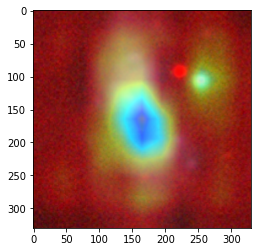

In [29]:
plt.imshow(visualization)

In [16]:
!pip install torch-lucent

     |████████████████████████████████| 46 kB 1.1 MB/s eta 0:00:011
     |████████████████████████████████| 225 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 1.6 MB/s eta 0:00:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=59ed4b47ecbeed23d5cb5ab4978a30131c239d31efc508a8253382eece603867
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [17]:
from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo.util import get_model_layers

In [18]:
get_model_layers(model)

['encoder',
 'encoder_stem',
 'encoder_stem_conv1',
 'encoder_stem_bn1',
 'encoder_stem_relu',
 'encoder_stem_maxpool',
 'encoder_layer1',
 'encoder_layer1_0',
 'encoder_layer1_0_conv1',
 'encoder_layer1_0_bn1',
 'encoder_layer1_0_conv2',
 'encoder_layer1_0_bn2',
 'encoder_layer1_0_conv3',
 'encoder_layer1_0_bn3',
 'encoder_layer1_0_relu',
 'encoder_layer1_0_downsample',
 'encoder_layer1_0_downsample_0',
 'encoder_layer1_0_downsample_1',
 'encoder_layer1_1',
 'encoder_layer1_1_conv1',
 'encoder_layer1_1_bn1',
 'encoder_layer1_1_conv2',
 'encoder_layer1_1_bn2',
 'encoder_layer1_1_conv3',
 'encoder_layer1_1_bn3',
 'encoder_layer1_1_relu',
 'encoder_layer1_2',
 'encoder_layer1_2_conv1',
 'encoder_layer1_2_bn1',
 'encoder_layer1_2_conv2',
 'encoder_layer1_2_bn2',
 'encoder_layer1_2_conv3',
 'encoder_layer1_2_bn3',
 'encoder_layer1_2_relu',
 'encoder_layer2',
 'encoder_layer2_0',
 'encoder_layer2_0_conv1',
 'encoder_layer2_0_bn1',
 'encoder_layer2_0_conv2',
 'encoder_layer2_0_bn2',
 'encode

100%|██████████| 512/512 [00:08<00:00, 59.95it/s]



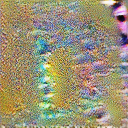

In [32]:
model.eval()
_ = render.render_vis(model, "encoder_layer4_2_conv3:127", show_inline=True, save_image=False)

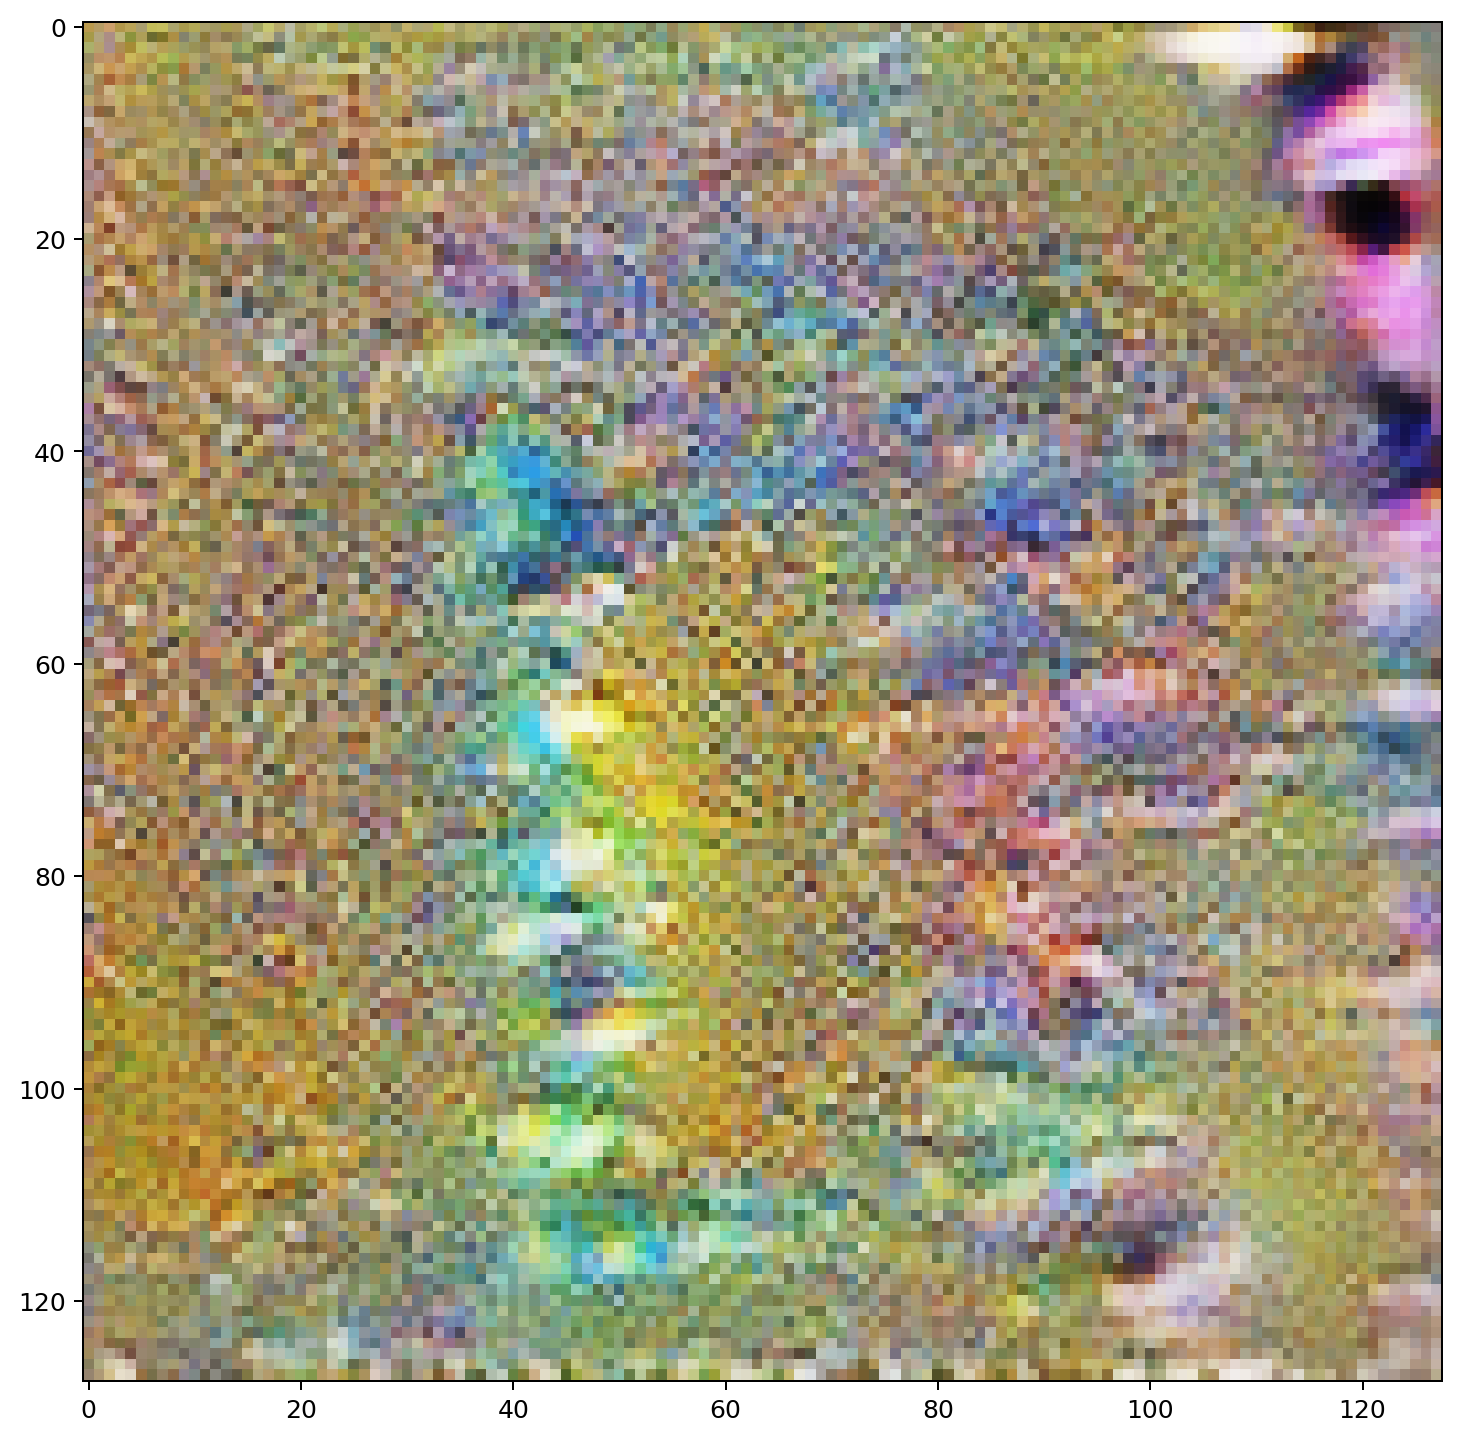

In [33]:
plt.figure(figsize=(10,10),dpi=180)
plt.imshow(_[0][0])
plt.show()

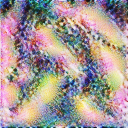

In [21]:
from PIL import Image
im1 = Image.fromarray(np.uint8(_[0][0]*255))
im1

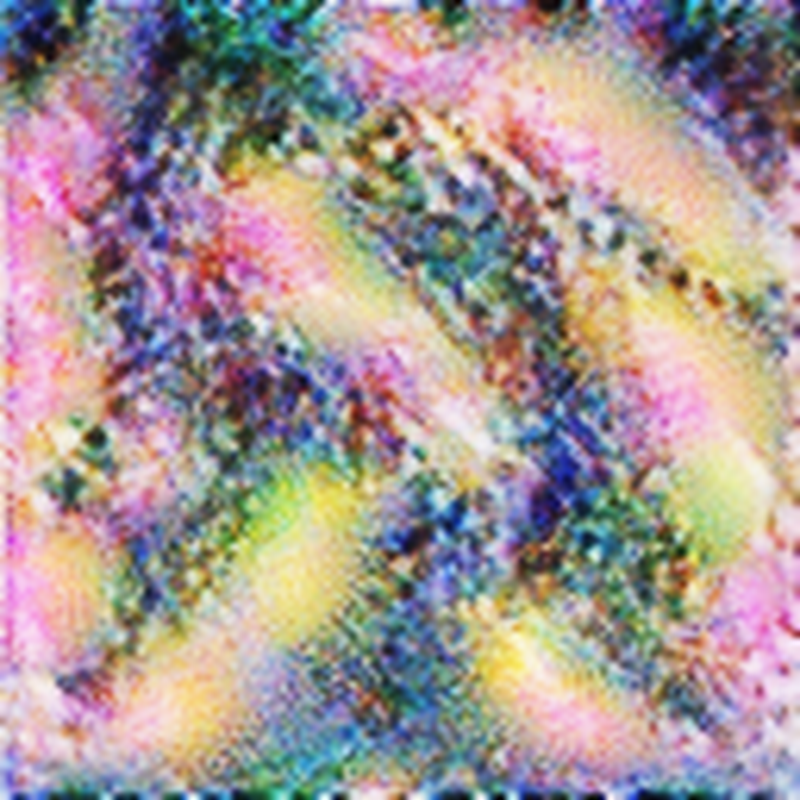

In [22]:
im1 = im1.resize((800,800), Image.LANCZOS)
im1

In [23]:
#im1.save('supervised_head:1.png')